## Seismic Analysis of Buried Pipelines

In [204]:
#Directory

In [205]:
cd /Users/Ram/Dropbox/PyBackUp/Pipeline/

/Users/Ram/Dropbox/PyBackUp/Pipeline


In [206]:
#Dependency
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import sd
from sd.dist import Distance
from scipy.stats import expon, lognorm
from sd.plot import plot_fragility_curve
import fiona
import ipyleaflet
from ipyleaflet import Marker
from ipyleaflet import Map
from pyproj import Proj
from pyproj import Proj, transform

In [207]:
np.random.seed(100000)

### Data import

In [208]:
# read node and link positions
node = pd.read_csv('node_demo.csv')
# link = pd.read_csv('edge classify.csv')
link = pd.read_csv('pipe_demo.csv')

In [209]:
# link.drop(['PipID','Length','dia'], axis=1, inplace=True)

In [210]:
# node['xx']=transform(Proj(init='epsg:4326'),Proj(init='epsg:3395'),node.x[0],node.y[0])[0]
# node['yy']=transform(Proj(init='epsg:4326'),Proj(init='epsg:3395'),node.x[0],node.y[0])[1]

### Define Earthquake Epicenter:

In [211]:
# Define expicenter coordinates (check with above command)
ex=-13589706.28220519; #this is longitude of the epicenter
ey=4592436.47339457; #this is latitude of the epicenter
M=7 # Richter Magnitude

### Transform coordinates to utm

In [212]:
# trasforming latlong into mercetor coordinates
def tran(data):    
    utmxy = {}
    rx=[]
    ry=[]
    for index, row in data.iterrows():
        x = row['x']
        y = row['y']
        inProj = Proj(init='epsg:4326')
        outProj = Proj(init='epsg:3395')
        cz = transform(inProj,outProj,x,y)
#         utmxy[int(row['id'])]=(c,z)
        r1=cz[0]
        r2=cz[1]
        rx.append(r1)
        ry.append(r2)
    rx=np.array(rx)
    ry=np.array(ry)
    return rx,ry

In [19]:
rx,ry=tran(node)

In [20]:
node_id = list(node.id)
rx = list(rx)
ry = list(ry)
typ = list(node.type)
dn1 = {'id':node_id,'x':rx,'y':ry,'type':typ}
df1=pd.DataFrame(dn1)
# df1.set_index('id');

### Distance Check and Measure Length of  Links

In [22]:
# check the distance between two different points
L1=df1.x[3],df1.y[3]
L2=df1.x[5],df1.y[5]
dist = distance.euclidean(L1, L2)
print(dist/1000, "km")

14.298549230891647 km


In [23]:
# data1 and data2 should be node and link, respectively
def Length(data1,data2):  
    dist=[]
    for index, row in data2.iterrows():
        sp=data1[data1.id==row['start_node']]
        start_x, start_y = (list(sp.x),list(sp.y))
        ep=data1[data1.id==row['end_node']]
        end_x,end_y=(list(ep.x),list(ep.y))
        lal = distance.euclidean((start_x, start_y),(end_x,end_y))
        dist.append(lal)
    dist=np.array(dist)
    return dist

In [24]:
link['link_m']=list(Length(node,link))

### Classify and plot various components

In [213]:
# node types
a = node[node['type']==1]
b = node[node['type']==2]
c = node[node['type']==3]

In [214]:
# pipe types
p1 = link[link['type']==1]
p2 = link[link['type']==2]

In [215]:
# calculate distances,intensity from epicenter
r1, pga1, pgv1, pos1 = Distance.com_pga_dist(a,ex,ey,M)
r2, pga2, pgv2, pos2 = Distance.com_pga_dist(b,ex,ey,M)
r3, pga3, pgv3, pos3 = Distance.com_pga_dist(c,ex,ey,M)

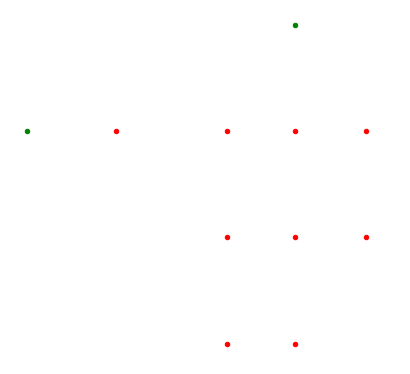

In [216]:
# plot graps with various components
G1=nx.Graph()
G1.add_nodes_from(pos1)
G2=nx.Graph()
G2.add_nodes_from(pos2)
G3=nx.Graph()
G3.add_nodes_from(pos3)
nx.draw(G1,pos1,node_size=20,node_color='r',with_labels=False)
nx.draw(G2,pos2,node_size=20,node_color='b',with_labels=False)
nx.draw(G3,pos3,node_size=20,node_color='g',with_labels=False)

In [217]:
r, pga, pgv, pos = Distance.com_pga_dist(node,ex,ey,M)

In [218]:
d1 = []
for index, row in p1.iterrows():
    stt = str(row['start_node'])+str(row['end_node']).rjust(10)
    d1.append(stt)
d2 = []
for index, row in p2.iterrows():
    stt = str(row['start_node'])+str(row['end_node']).rjust(10)
    d2.append(stt)

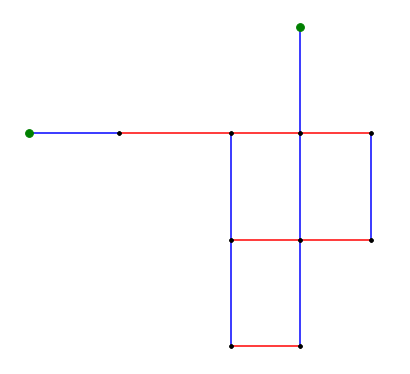

In [219]:
# draw Graph of water network
G4 = nx.parse_edgelist(d1,nodetype=int)
G5 = nx.parse_edgelist(d2,nodetype=int)
nx.draw(G4,pos,node_size=10, node_color='k', edge_color='r',width=1.5)
nx.draw(G5,pos,node_size=10, node_color='k', edge_color='b',width=1.5)
nx.draw(G1,pos1,node_size=10,node_color='k',with_labels=False)
nx.draw(G2,pos2,node_size=10,node_color='k',with_labels=False)
nx.draw(G3,pos3,node_size=60,node_color='g',with_labels=False)
plt.savefig('Demo_Network.png', dpi = 600,bbox_inches='tight')

### PGA for nodes

In [32]:
d = []
for index, row in link.iterrows():
    stt = str(row['start_node'])+str(row['end_node']).rjust(10)
    d.append(stt)

In [33]:
r, pga, pgv, pos = Distance.com_pga_dist(node,ex,ey,M)

In [34]:
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))

In [35]:
node_list = list(G.nodes)
pf = {'node_list':node_list}
n_list=pd.DataFrame(pf)

In [37]:
node_pga = list(pga)
node_pgv = list(pgv)
ind= list(pos)
pf = {'node_pga':node_pga,'node_pgv':node_pgv,'pid':ind}
n_int=pd.DataFrame(pf)
# n_int.set_index('pid',inplace=True)

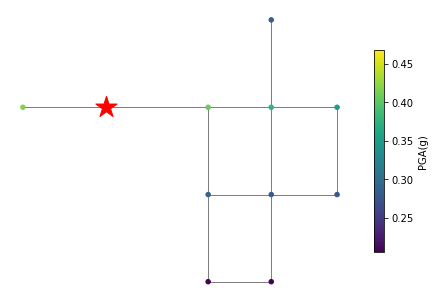

In [40]:
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
# jet=plt.cm.jet
nx.draw(G,pos,node_size=20,edge_color = 'k',node_color=n_out.node_pga,width=0.5,with_labels=False)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(n_out.node_pga.min(), n_out.node_pga.max()))
plt.colorbar(sm,label='PGA(g)',shrink=0.7)
plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_Node_PGA.png', dpi = 600,bbox_inches='tight')

In [41]:
Min, Mean, Max={n_out.node_pga.min(),n_out.node_pga.mean(), n_out.node_pga.max()}
Min, Mean, Max

(0.20628846029464096, 0.3244917516489607, 0.468126922903879)

### PGV for nodes

In [42]:
#convert pgv(m/s) to pgv(in/s)
node_pgv=n_out.node_pgv*100

### PGA for Pipelines

In [55]:
pipe_pga=p_out.link_pga

### PGV for Pipelines

In [57]:
pipe_pgv=p_out.link_pgv*39.3701

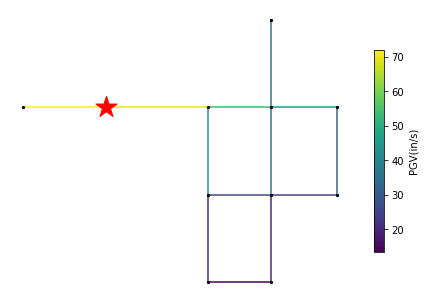

In [58]:
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
jet=plt.cm.jet
nx.draw(G,pos,node_size=5,edge_color =pipe_pgv, node_color='k',width=1.5,with_labels=False)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(pipe_pgv.min(), pipe_pgv.max()))
plt.colorbar(sm,label='PGV(in/s)',shrink=0.7)
plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_Link_PGV.png', dpi = 600,bbox_inches='tight')

In [59]:
Min, Mean, Max={pipe_pgv.min(),pipe_pgv.mean(), pipe_pgv.max()}
Min, Mean, Max

(72.01221363726988, 37.774767771129845, 13.472550662417833)

### ALA Repair Rates

In [60]:
r_rate=0.00187*pipe_pgv

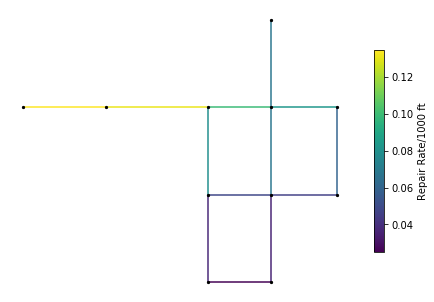

In [61]:
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
jet=plt.cm.jet
nx.draw(G,pos,node_size=5,edge_color =r_rate, node_color='k',width=1.5,with_labels=False)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(r_rate.min(), r_rate.max()))
plt.colorbar(sm,label='Repair Rate/1000 ft',shrink=0.7)
# plt.scatter(ex, ey, s=1000, c='r', marker='*', zorder=2)
plt.savefig('Demo_repair_rate.png', dpi = 600,bbox_inches='tight')

In [62]:
value=r_rate
Min, Mean, Max={value.min(),value.mean(), value.max()}
Min, Mean, Max

(0.025193669738721346, 0.13466283950169466, 0.07063881573201279)

### Correction Factors

In [74]:
pipe_characteristics = pd.read_csv('pipe_demo.csv',dtype={'index':str})

In [75]:
pipe_characteristics.set_index('PipID',inplace=True)

In [76]:
pipe_characteristics.head(2)

,start_node,end_node,type,Length,dia,M_type,Material,soil_type,age
PipID,,,,,,,,,
119,10,11,1,570,24,CI,CIP,H,1930
121,11,12,1,240,16,CI,CIP,M,1930


In [77]:
C=sd.cf.correction_factor(pipe_characteristics)

In [78]:
link_id=list(C.index)
link_C=list(C)
pf = {'Id':pipe_id,'C':link_C}
c_list=pd.DataFrame(pf)
c_list.tail(2)

,Id,C
11,139,2.5
12,141,2.5


In [79]:
G = nx.parse_edgelist(dp, nodetype = int, data=(('id',int),))
edges= nx.get_edge_attributes(G,'id')
edge_list=list(edges.values())
pk = {'el':edge_list}
c_adj=pd.DataFrame(pk)
c_adj.tail(2)

,el
11,139
12,125


In [80]:
c_fact=c_adj.merge(c_list, left_on='el', right_on='Id')

In [81]:
c_fact.tail(2)

,el,Id,C
11,139,139,2.50
12,125,125,0.75


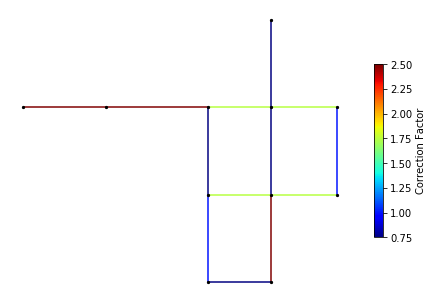

In [82]:
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =c_fact.C, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(c_fact.C.min(), c_fact.C.max()),cmap = c_color)
plt.colorbar(sm,label='Correction Factor',shrink=0.6)
# plt.scatter(ex, ey, s=1000, c='r', marker='*', zorder=2)
plt.savefig('Demo_Correc_Factor.png', dpi = 600,bbox_inches='tight')

### Table_Merged

In [83]:
nn=c_adj.merge(link, left_on='el', right_on='PipID')

In [84]:
rkk=nn.merge(p_out, left_on='el', right_on='Id')

In [85]:
out=rkk.merge(c_fact, left_on='el_x', right_on='el')

In [86]:
out.head(2)

,el_x,start_node,end_node,type,PipID,Length,dia,M_type,Material,soil_type,age,link_m,el_y,Id_x,link_pga,link_pgv,el,Id_y,C
0,119,10,11,1,119,570,24,CI,CIP,H,1930,3575.771287,119,119,0.438575,1.782180,119,119,2.5
1,141,9,10,2,141,190,24,CI,CIP,H,1930,2894.440344,141,141,0.443740,1.829109,141,141,2.5


### Modified Repair Rate (per 1000 ft) considering Correction Factors

In [93]:
Mod_RR=0.00187*out.link_pgv*39.3701*out.C

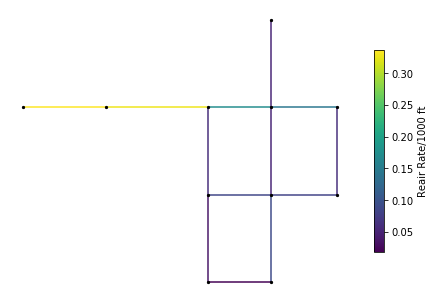

In [94]:
edge_value=Mod_RR
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()))
plt.colorbar(sm,label='Reair Rate/1000 ft',shrink=0.7)
# plt.scatter(ex, ey, s=1000, c='r', marker='*', zorder=2)
plt.savefig('Demo_Mod_RR.png', dpi = 600,bbox_inches='tight')

In [95]:
Min, Mean, Max={Mod_RR.min(),Mod_RR.mean(), Mod_RR.max()}

In [96]:
Min, Mean, Max

(0.01889525230404101, 0.33665709875423666, 0.11682231612038366)

### New Control Variable (Θ)

In [97]:
C_PGV_L=(out.C)*(out.link_pgv*39.3701)*(out.link_m*3.28084/1000)

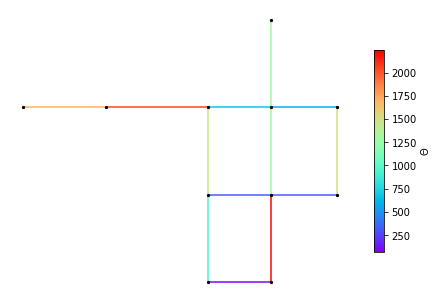

In [98]:
edge_value=C_PGV_L
c_color=plt.cm.rainbow
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Θ',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_C_PGV_L.png', dpi = 600,bbox_inches='tight')

In [99]:
Min, Mean, Max={C_PGV_L.min(),C_PGV_L.mean(), C_PGV_L.max()}
Min, Mean, Max

(73.06003844690976, 2243.3439604765795, 1110.2975583580283)

### Pipe Age

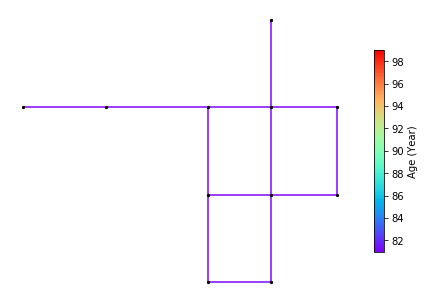

In [100]:
edge_value=2020-out.age
c_color=plt.cm.rainbow
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Age (Year)',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_Age.png', dpi = 600,bbox_inches='tight')

### Probability of Failure

#### Pipe Leak

In [101]:
P_leak=1-np.exp(-0.00187*C_PGV_L)

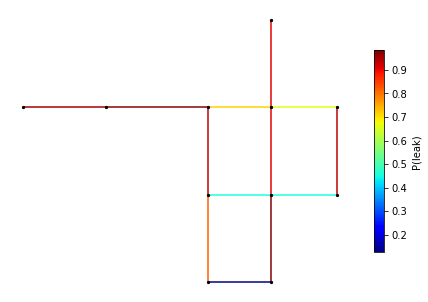

In [102]:
edge_value=P_leak
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='P(leak)',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_P_leak.png', dpi = 600,bbox_inches='tight')

#### Pipe Break

In [103]:
P_break=P_leak*0.25

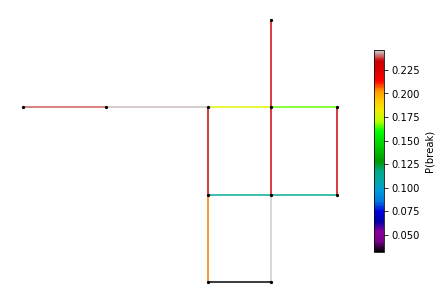

In [104]:
edge_value=P_break
c_color=plt.cm.nipy_spectral
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='P(break)',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_P_break.png', dpi = 600,bbox_inches='tight')

# Damage States

### Node damage simulations

In [105]:
np.random.seed(10000)

In [107]:
r, pga, pgv, pos = Distance.com_pga_dist(node,ex,ey,M)

In [108]:
node_id = list(node.id)
pga_val = list(pga)
dn1 = {'Id':node_id,'pga1':pga_val}
df1=pd.DataFrame(dn1)
df1.set_index('Id',inplace=True);

In [110]:
np.random.seed(12345)
node_Pr = node_FC.cdf_probability(df1['pga1'])
node_damage_state = node_FC.sample_damage_state(node_Pr)
node_damage_state_map = node_FC.get_priority_map()
node_damage_val = node_damage_state.map(node_damage_state_map)
node_damage_val.value_counts()

0    7
1    4
dtype: int64

In [112]:
node_damage_val;

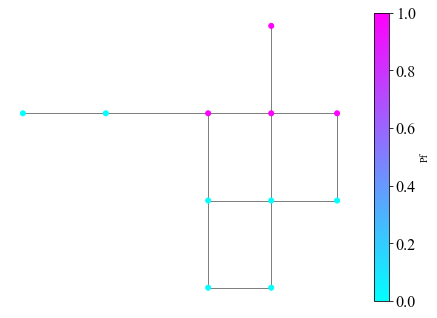

In [113]:
edge_value=node_damage_val
c_color=plt.cm.cool
nx.draw(G,pos,node_size=25,edge_color ='k', node_color=edge_value, width=0.5,with_labels=False,cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Pf')
plt.savefig('Demo_Source_Damage.png', dpi = 600,bbox_inches='tight')

### Pipe damage simulations

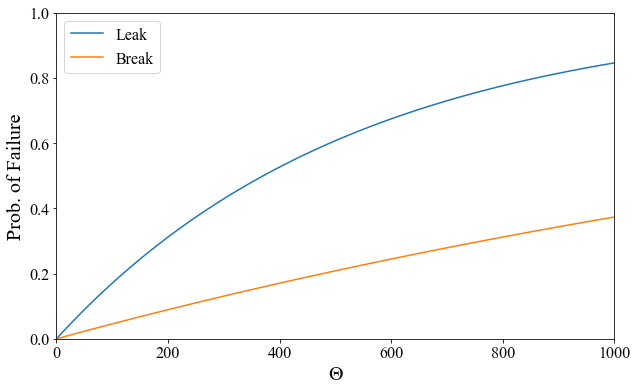

In [114]:
pipe_FC = sd.FragilityCurve()
pipe_FC.add_state('Break', 2, {'Default': expon(scale=1/(0.00187*.25))})
pipe_FC.add_state('Leak', 1, {'Default': expon(scale=1/(0.00187))})
plot_fragility_curve(pipe_FC, xlabel='Θ', ylabel='Prob. of Failure',fill=False,xmax=1000)
plt.xlabel('Θ',size=20)
plt.ylabel('Prob. of Failure',size=20)
plt.legend(prop={'size':16},loc='upper left')
plt.rc('font',family='Times New Roman')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.grid(False)
plt.savefig('Fragility.png', dpi = 600,bbox_inches='tight')

In [115]:
pga_link,pgv_link = Distance.pga_for_link(link,node,ex,ey,M)

In [116]:
p11_id = list(link.PipID)
p11_pga=list(pgv_link)
p11_len=list(out.link_m)
CV=list(C_PGV_L)
pk = {'Id':p11_id,'pgv':p11_pga,'len':p11_len,'CV':C_PGV_L}
pip_f=pd.DataFrame(pk)
pip_f.set_index('Id',inplace=True)

In [118]:
np.random.seed(12345)
pipe_Pr = pipe_FC.cdf_probability(pip_f['CV'])
pipe_damage_state = pipe_FC.sample_damage_state(pipe_Pr)
pipe_damage_state_map = pipe_FC.get_priority_map()
pipe_damage_val = pipe_damage_state.map(pipe_damage_state_map)
pipe_damage_val.value_counts()

1    6
2    4
0    3
dtype: int64

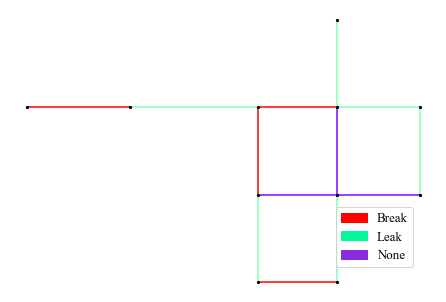

In [119]:
# plt.rcParams['figure.figsize'] = [5.5, 5]
edge_value=pipe_damage_val
c_color=plt.cm.rainbow
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)

red_patch = mpatches.Patch(color='red', label='Break')
cyan_patch = mpatches.Patch(color='mediumspringgreen', label='Leak')
blue_patch = mpatches.Patch(color='blueviolet', label='None')

plt.legend(handles=[red_patch,cyan_patch, blue_patch],loc=10,fontsize=13,bbox_to_anchor=(0.8, 0.0, 0.1, 0.4))
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=1)
plt.savefig('Demo_Damage_States.png', dpi = 600,bbox_inches='tight')

### Betweenness Centrality

In [120]:
bc_edge=list(nx.edge_betweenness_centrality(G).values())

In [121]:
ebc=pd.Series(bc_edge)

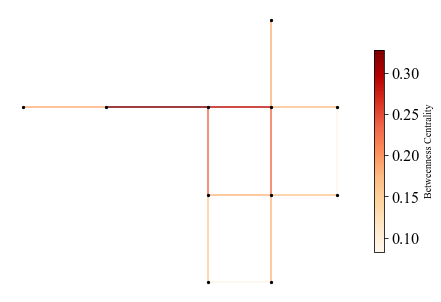

In [122]:
edge_value=ebc
c_color=plt.cm.OrRd
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Betweenness Centrality',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_EBC.png', dpi = 600,bbox_inches='tight')

In [123]:
bc_node=list(nx.betweenness_centrality(G).values())

In [124]:
nbc=pd.Series(bc_node)

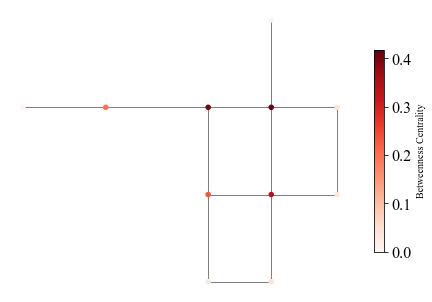

In [125]:
edge_value=nbc
c_color=plt.cm.Reds
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=20,edge_color ='k', node_color=edge_value,width=.5,with_labels=False,cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Betweenness Centrality',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_NBC.png', dpi = 600,bbox_inches='tight')

### Normalized EBC

In [126]:
ebc=pd.Series(bc_edge)

In [127]:
norm_ebc=(ebc-ebc.min())/(ebc.max()-ebc.min())

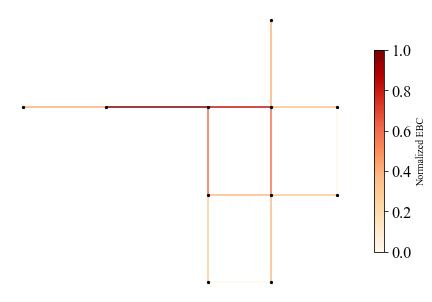

In [128]:
edge_value=norm_ebc
c_color=plt.cm.OrRd
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Normalized EBC',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_Norm_EBC.png', dpi = 600,bbox_inches='tight')

### Condition Index

In [129]:
pc_id = list(link.PipID)
pc_age=list(0.0003*(2020-out.age)**2-0.0003*(2020-out.age)+1)
pk = {'Id':pc_id,'CI':pc_age}
pc_f=pd.DataFrame(pk)
pc_f.set_index('Id',inplace=True)

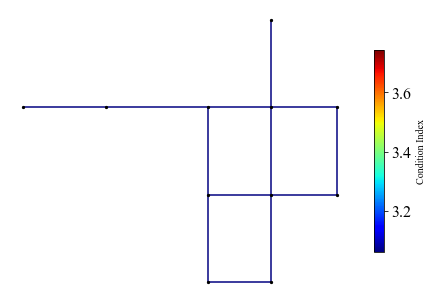

In [131]:
edge_value=pc_f.CI
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Condition Index',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_CI.png', dpi = 600,bbox_inches='tight')

### Normalized Condition Index

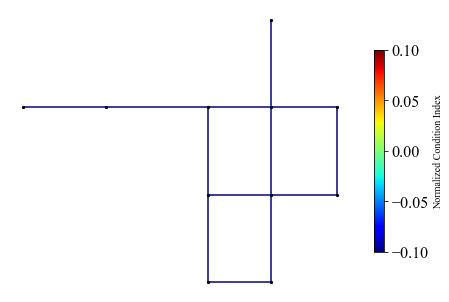

In [134]:
norm_CI=(pc_f.CI-pc_f.CI.min())/(pc_f.CI.max()-pc_f.CI.min())
edge_value=norm_CI
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='Normalized Condition Index',shrink=0.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_Norm_CI.png', dpi = 600,bbox_inches='tight')

### Maintenance Action

In [135]:
pc_id = list(link.PipID)

In [136]:
pc_id = list(link.PipID)
CI=list(norm_CI)
nbc=list(norm_ebc)
pk = {'Id':pc_id,'CI':CI,'nbc':norm_ebc}
cost=pd.DataFrame(pk)
cost.set_index('Id',inplace=True)

In [138]:
Index=cost.CI*0.7+cost.nbc*0.3

In [139]:
Index=cost.CI*0.7+cost.nbc*0.3
pc_id = list(link.PipID)
ind=list(Index)
dl=list(pipe_damage_val)
pk = {'Id':pc_id,'ind':ind,'dl':dl}
need=pd.DataFrame(pk)
need.set_index('Id',inplace=True)

In [141]:
mmm=need[(need.ind>0.5)&(need.dl>0)]

In [142]:
link['link_m']=list(Length(node,link))

In [144]:
# data1 and data2 should be node and link, respectively
def C_Check(data):  
    maint=[]
    for index,row in data.iterrows():
        if (row['ind']>=0.5) & (row['dl']>0):
            mm=2
        elif (row['ind']<0.5) & (row['dl']>0):
            mm=1
        else:
            mm=0
        maint.append(mm)
    maint=np.array(maint)
    return maint

In [145]:
need['MA']=list(C_Check(need))

In [146]:
need.MA.value_counts()

0    13
Name: MA, dtype: int64

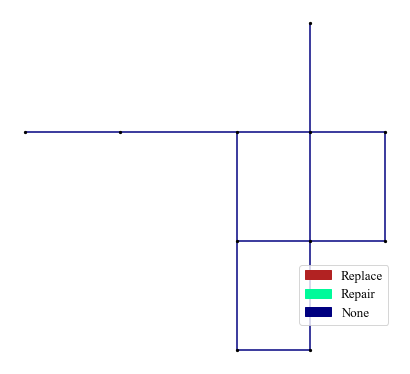

In [148]:
plt.rcParams['figure.figsize'] = [5.5, 5]
edge_value=need.MA
c_color=plt.cm.jet
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=5,edge_color =edge_value, node_color='k',width=1.5,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
red_patch = mpatches.Patch(color='firebrick', label='Replace')
cyan_patch = mpatches.Patch(color='mediumspringgreen', label='Repair')
blue_patch = mpatches.Patch(color='navy', label='None')

plt.legend(handles=[red_patch,cyan_patch, blue_patch],loc=10,fontsize=13,bbox_to_anchor=(0.8, 0.0, 0.1, 0.4))
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)
plt.savefig('Demo_MA.png', dpi = 600,bbox_inches='tight')

In [149]:
need[need.MA>=1].to_csv('pipe_repair.csv')

### Repair Cost Estimation

In [150]:
nw=need.merge(out, left_on='Id', right_on='el_x')

In [151]:
nw['NoB']=(0.00187*nw.link_pgv*39.3701*nw.C)*(nw.link_m*3.28084/1000)

In [152]:
nw.NoB;
nw['nNoB']=np.ceil(nw.NoB).astype(int)

In [154]:
xxx,yyy=pipe_annual_cost(nw)

In [155]:
nw['repair_C']=xxx
nw['replace_C']=yyy

In [156]:
def C_Est(data):  
    cost=[]
    for index,row in data.iterrows():
        if (row['MA']==1):
            mm=row['repair_C']*row['nNoB']
        elif (row['MA']==2):
            mm=row['replace_C']
        else:
            mm=0
        cost.append(mm)
    cost=np.array(cost)
    return cost

In [157]:
nw['T_Cost']=list(C_Est(nw))

In [158]:
Cost_for_repair=print(nw[nw.MA==1].T_Cost.sum())

0


In [159]:
Cost_for_replace=print(nw[nw.MA==2].T_Cost.sum())

0


In [160]:
total_maintenace_cost=print(nw.T_Cost.sum())

0


In [161]:
nw.head()

,ind,dl,MA,el_x,start_node,end_node,type,PipID,Length,dia,...,link_pga,link_pgv,el,Id_y,C,NoB,nNoB,repair_C,replace_C,T_Cost
0,NaN,1,0,119,10,11,1,119,570,24,...,0.438575,1.782180,119,119,2.50,3.848171,4,2300,1.233641e+07,0
1,NaN,2,0,121,11,12,1,121,240,16,...,0.393325,1.347938,121,121,1.75,1.255697,2,1300,4.297525e+06,0
2,NaN,2,0,122,12,13,1,122,440,24,...,0.364288,1.123664,122,122,1.75,1.092538,2,2300,7.935748e+06,0
3,NaN,2,0,123,21,22,1,123,220,16,...,0.286741,0.659291,123,123,1.75,0.614175,1,1300,4.297525e+06,0
4,NaN,1,0,124,22,23,1,124,300,24,...,0.280278,0.628391,124,124,1.75,0.610985,1,2300,7.935748e+06,0


#### Repairable Length

In [162]:
nw[nw.MA>0].link_m.sum()/1000

0.0

In [163]:
nw[nw.MA>1].link_m.sum()/1000

0.0

In [164]:
#Per_Cost_graph

In [165]:
# diameter = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 30, 32, 34] # inch
# rpr = [95, 120, 140, 165, 195, 220, 255, 385, 455, 525, 563, 600, 638, 638] # repair cost
# rpl = [1575, 1800, 2270, 2700, 2800, 3000, 4225, 4325, 4450, 4450, 4450, 4450, 4450, 4450] # replace cost
# repair_cost = pd.Series(rpr,diameter)        
# replace_cost = pd.Series(rpl,diameter)        

# xp=replace_cost.index
# yp1=replace_cost.values
# yp2=repair_cost.values
# plt.plot(xp,yp1)
# plt.plot(xp,yp2)
# plt.xlabel('Diameter(in)',size=16)
# plt.ylabel('Cost $',size=16)
# plt.rc('font',family='Times New Roman')
# plt.savefig('Cost_Graph.png', dpi = 600,bbox_inches='tight')

In [166]:
Costt=nw.T_Cost

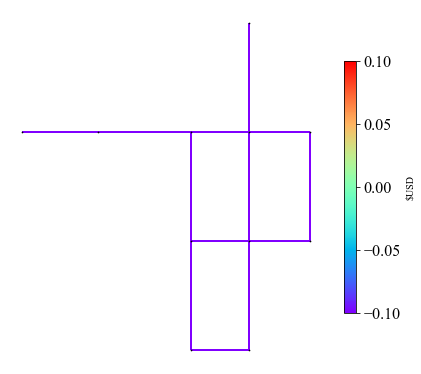

In [167]:
edge_value=Costt
c_color=plt.cm.rainbow
G = nx.parse_edgelist(d, nodetype = int, data=(('id',int),))
nx.draw(G,pos,node_size=0.5,edge_color =edge_value, node_color='k',width=2,with_labels=False,edge_cmap = c_color)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(edge_value.min(), edge_value.max()),cmap = c_color)
plt.colorbar(sm,label='$USD',shrink=.7)
# plt.scatter(ex, ey, s=500, c='r', marker='*', zorder=2)

In [168]:
# nx.shortest_path(G, 1721);

In [169]:
# pd.Series(nx.single_source_shortest_path(G,1721));

### Isolated Graph after removing damaged components

In [170]:
n_link=nw[nw.MA==0]

In [171]:
pp = []
for index, row in n_link.iterrows():
    stt = str(row['start_node'])+str(row['end_node']).rjust(10)
    pp.append(stt)

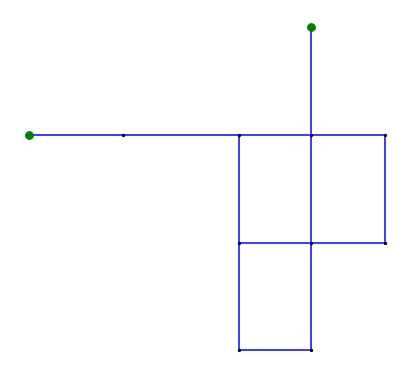

In [172]:
# draw Graph of water network
G = nx.parse_edgelist(pp,nodetype=int)
nx.draw(G,pos,node_size=5, node_color='k', edge_color='b',width=1.5)
nx.draw(G3,pos3,node_size=60,node_color='g',with_labels=False)
plt.savefig('Demo_Isolated.png', dpi = 600,bbox_inches='tight')

In [173]:
nx.number_of_isolates(G)

0

### Plot Networks

In [174]:
# read node and link positions
node = pd.read_csv('node_demo.csv')
# link = pd.read_csv('edge classify.csv')
link = pd.read_csv('pipe_demo.csv')

In [175]:
import os
import folium
from folium.plugins.measure_control import MeasureControl

In [176]:
link.head(1)

,start_node,end_node,type,PipID,Length,dia,M_type,Material,soil_type,age
0,10,11,1,119,570,24,CI,CIP,H,1930


In [177]:
# data1 and data2 should be node and link, respectively
def Coord(data1,data2):  
    pos={}
    ll=[]
    for index, row in data2.iterrows():
        sp=data1[data1.id==row['start_node']]
        start_x, start_y = (list(sp.x),list(sp.y))
        ep=data1[data1.id==row['end_node']]
        end_x,end_y=(list(ep.x),list(ep.y))
        pos[int(row['PipID'])]=start_y+start_x,end_y+end_x
        ll=data2['Length']
    return pos, ll

In [178]:
posL,ll=Coord(node,link)

In [179]:
coordinatesL=posL.values()

In [180]:
coL=list(coordinatesL)

In [181]:
# Create the map and add the line
m = folium.Map(location=[38.28409957,-122.0654925], zoom_start=14)
# folium.TileLayer('cartodbpositron').add_to(m)

# linear = cm.LinearColormap(
#     ['green', 'yellow', 'red'],
#     vmin=3, vmax=10)

# o=folium
folium.PolyLine(coL, color='blue',weight=2, opacity=0.7).add_to(m)
# folium.LayerControl().add_to(m)

m;

In [182]:
bc_node=nx.betweenness_centrality(G)
bc_node;

In [183]:
bc_edge=nx.edge_betweenness_centrality(G)
bc_edge;

In [184]:
r, pga, pgv, pos = Distance.com_pga_dist(node,ex,ey,M)

In [185]:
link_attribute=bc_edge
link_width=2
link_range=[0,1]
link_cmap_bins='cut'
link_cmap=['cornflowerblue', 'forestgreen', 'gold', 'firebrick']

In [186]:
link.head(1)

,start_node,end_node,type,PipID,Length,dia,M_type,Material,soil_type,age
0,10,11,1,119,570,24,CI,CIP,H,1930


In [187]:
node.head()

,id,x,y,type
0,10,-122.078409,38.278968,1
1,11,-122.046287,38.278968,1
2,12,-122.026489,38.278968,1
3,13,-122.005826,38.278968,1
4,21,-122.046287,38.178968,1


In [188]:
def Loc(data):  
    pos={}
    for index, row in data.iterrows():
        loc = (row['y'], row['x'])
        pos[int(row['id'])]=loc

    return pos

In [189]:
posN=Loc(node)

In [190]:
# coordinates=pos.values()
# co=list(coordinates)
# list(coordinates);

In [191]:
link_v=need.MA
node_v=n_out.node_pga

In [193]:
plot_leaflet_network(G,node_attribute=node_v,link_attribute=link_v,link_width=2,filename='N_P.html')

In [194]:
# Stamen Terrain
# Stamen Toner

In [195]:
link_v=P_leak
node_v=n_out.node_pga

In [196]:
node_size=2
node_attribute=node_v
link_attribute=link_v
node_range=[None,None]
node_cmap_bins = 'cut'
link_cmap_bins='cut'
node_cmap=['cornflowerblue', 'forestgreen', 'gold', 'firebrick'] 
link_cmap=['cornflowerblue', 'forestgreen', 'gold', 'firebrick']